# Building Advanced Transformers

## What is a Transformer?

The Transformer architecture was introduced in the paper *"Attention Is All You Need"*. It revolutionized natural language processing by using attention mechanisms instead of recurrence.

### Key Components:
- **Input Embedding:** Converts input tokens (or time steps) into vectors.
- **Positional Encoding:** Injects information about the position of input tokens.
- **Multi-Head Self-Attention:** Allows the model to focus on different parts of the input sequence.
- **Feedforward Layers:** Process the attended information.
- **Layer Normalization & Residual Connections:** Stabilize and speed up training.

> Transformers are now widely used not only in NLP but also in time series forecasting, image recognition, and more.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

## Generate synthetic stock price data

In [2]:
# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print('Synthetic stock_prices.csv created and loaded.')

Synthetic stock_prices.csv created and loaded.


In [5]:
# Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [6]:
# Prepare the data for training
def create_dataset(data, time_step=1):
  X, Y = [], []
  for i in range(len(data) - time_step - 1):
    a = data[i:(i + time_step), 0]
    X.append(a)
    Y.append(data[i + time_step, 0])
  return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


## Implement Multi-Head Self-Attention

In the code below: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


In [7]:
class MultiHeadSelfAttention(Layer):
  def __init__(self, embed_dim, num_heads=8):
    super(MultiHeadSelfAttention, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.projection_dim = embed_dim // num_heads
    self.query_dense = Dense(embed_dim)
    self.key_dense = Dense(embed_dim)
    self.value_dense = Dense(embed_dim)
    self.combine_heads = Dense(embed_dim)

  def attention(self, query, key, value):
    score = tf.matmul(query, key, transpose_b=True)
    dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_score = score / tf.math.sqrt(dim_key)
    weights = tf.nn.softmax(scaled_score, axis=-1)
    output = tf.matmul(weights, value)
    return output, weights

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    query = self.query_dense(inputs)
    key = self.key_dense(inputs)
    value = self.value_dense(inputs)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)
    attention, _ = self.attention(query, key, value)
    attention = tf.transpose(attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
    output = self.combine_heads(concat_attention)
    return output

## Implement Transformer block

In the code below:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


In [8]:
class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadSelfAttention(embed_dim, num_heads)
    self.ffn = tf.keras.Sequential([
      Dense(ff_dim, activation='relu'),
      Dense(embed_dim)
    ])
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)
  

## Implement Encoder Layer

In the code below: 

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture. 

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


In [10]:
class EncoderLayer(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(EncoderLayer, self).__init__()
    self.att = MultiHeadSelfAttention(embed_dim, num_heads)
    self.ffn = tf.keras.Sequential([
      Dense(ff_dim, activation='relu'),
      Dense(embed_dim)
    ])
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

## Implement Transformer Encoder

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture.

In [11]:
class TransformerEncoder(Layer):
  def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerEncoder, self).__init__()
    self.num_layers = num_layers
    self.embed_dim = embed_dim
    self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.dropout = Dropout(rate)

  def call(self, inputs, training=False):
    x = inputs
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training=training)
    return x

# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)
print(outputs.shape)

(1, 100, 128)


## Build and compile the Transformer model

In the code below: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


In [12]:
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Transformer model

In [13]:
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 6.5022
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - loss: 0.2048
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 0.1711
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - loss: 0.1880
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - loss: 0.2013
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - loss: 0.1332
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - loss: 0.1383
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - loss: 0.1314
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - loss: 0.1732
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - loss: 0.1251
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step - loss: 0.1245
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - loss: 0.1630
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - loss: 0.1258
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.0973
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 

## Evaluate and make predictions

In the code below: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step


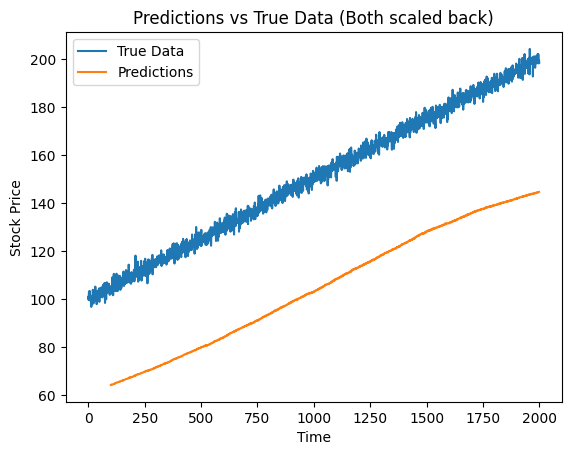

In [16]:
import matplotlib.pyplot as plt

predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

true_values = scaler.inverse_transform(data.reshape(-1, 1))

plt.plot(true_values, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data (Both scaled back)')
plt.show()

# Exercise 1

**Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 

In [17]:
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = tf.keras.layers.Dropout(0.5)(flatten)

outputs = tf.keras.layers.Dense(1)(dropout)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20, batch_size=32)

loss = model.evaluate(X, Y)
print(f'Test loss: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 4.0910
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 1.2948
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.9550
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - loss: 0.4112
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - loss: 0.1686
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0850
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0521
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - loss: 0.0339
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 0.0301
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0237
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.0197
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 0.0210
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 0.0188
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 0.0158
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 

## Exercise 2

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 

In [18]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.0249
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.0471
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0383
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0233
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - loss: 0.0190
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0208
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.0259
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0255
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0278
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0261
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0275
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0512
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.0355
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0205
Epoch 15/20
119/

## Exercise 3

**Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


In [19]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - loss: 0.0853
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 0.0168
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0096
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0063
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0053
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0080
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0038
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0033
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.0041
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0033
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0047
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0037
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0029
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0106
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 